In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

from renewable_data_load import *

import time

In [2]:
ls ../../data/demand/DailyPeaks/PGE_daily_peaks_reference_2025.csv

../../data/demand/DailyPeaks/PGE_daily_peaks_reference_2025.csv


# 0. Load data

In [3]:
# load and merge data from each region
peak_load_directory = "../../data/demand/DailyPeaks/"
# get list of csv files in directory
import os
csv_files = [f for f in os.listdir(peak_load_directory) if f.endswith('.csv')]

region_datasets = []  # Collect datasets with region names

for file in csv_files:
    region_name = file.split('_')[0]  # assuming the format is REGION_daily_peaks_reference_2025.csv
    df = pd.read_csv(os.path.join(peak_load_directory, file))
    df = df.rename(columns={'Date': 'time'})
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    # Add region name as coordinate
    ds = ds.expand_dims({'region': [region_name]})
    region_datasets.append(ds)

# Concatenate all regions with their names
peak_demand_ds = xr.concat(region_datasets, dim='region')

peak_demand_ds['time'] = pd.to_datetime(peak_demand_ds.time.values)
peak_demand_ds = peak_demand_ds.convert_calendar("noleap")

In [4]:
peak_demand_ds.region

<xarray.DataArray 'region' (region: 9)> Size: 72B
array(['SCE', 'IID', 'NCNC', 'LDWP', 'WECC-MTN', 'WECC-SW', 'PGE', 'SDGE',
       'WECC-NW'], dtype=object)
Coordinates:
  * region   (region) object 72B 'SCE' 'IID' 'NCNC' ... 'PGE' 'SDGE' 'WECC-NW'

In [5]:
peak_demand_ds = peak_demand_ds.rename({'EC_EARTH3':'ec-earth3',
                                        'MIROC6':'miroc6',
                                        'MPI_ESM1_2_HR':'mpi-esm1-2-hr',
                                        'TAIESM1':'taiesm1'})

# 1. Calculate high-demand threshold levels for each region

In [6]:
# Set parameters
window_size = 60  # 60-day window for seasonal normalization
reference_gwl = 0.8 # reference period used to define threshold

In [7]:
# Create rolling window

regional_thresholds = {}

for simulation in peak_demand_ds.data_vars:
    peak_demand_da = peak_demand_ds[simulation]

    print(f"Calculating drought mask for GWL: {reference_gwl}°C")
    # Get bounds for reference GWL period
    WRF_sim_name = sim_name_dict[simulation]
    model = WRF_sim_name.split("_")[1]
    ensemble_member = WRF_sim_name.split("_")[2]
    ref_start_year, ref_end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)

    peak_demand_da = peak_demand_da.sel(time=slice(f"{ref_start_year}-01-01",f"{ref_end_year}-12-31"))

    test_window = peak_demand_da.rolling(time=window_size, center=True).construct("window")
    test_window = test_window.assign_coords({"window": [w for w in np.arange(1, window_size+1, 1)]})

    # Convert time coordinate to datetime64 to enable .dt accessor
    #test_window['time'] = pd.to_datetime(test_window.time.values)

    # Add dayofyear and year coordinates
    test_window['dayofyear'] = test_window.time.dt.dayofyear
    test_window['year'] = test_window.time.dt.year
    test_window = test_window.assign_coords({
        "dayofyear": test_window.time.dt.dayofyear,
        "year": test_window.time.dt.year
    })

    # Reshape time dimension to separate dayofyear and year
    test_window = test_window.drop_vars("time").set_index(time=['dayofyear', 'year']).unstack()

    # Stack window and year into sample dimension
    test_window = test_window.stack(sample=["window", "year"])

    # Compute 90th percentile across samples for each day-of-year (high demand threshold)
    percentile_90 = test_window.quantile(0.9, dim='sample')

    print(f"Threshold shape: {percentile_90.dims}")

    percentile_90.to_netcdf(f'../../data/thresholds/demand_WECC_regions_{simulation}_90th_pctile.nc')

    regional_thresholds[simulation] = percentile_90

Calculating drought mask for GWL: 0.8°C
Threshold shape: ('region', 'dayofyear')
Calculating drought mask for GWL: 0.8°C
Threshold shape: ('region', 'dayofyear')
Calculating drought mask for GWL: 0.8°C
Threshold shape: ('region', 'dayofyear')
Calculating drought mask for GWL: 0.8°C
Threshold shape: ('region', 'dayofyear')


### Visualize Threshold

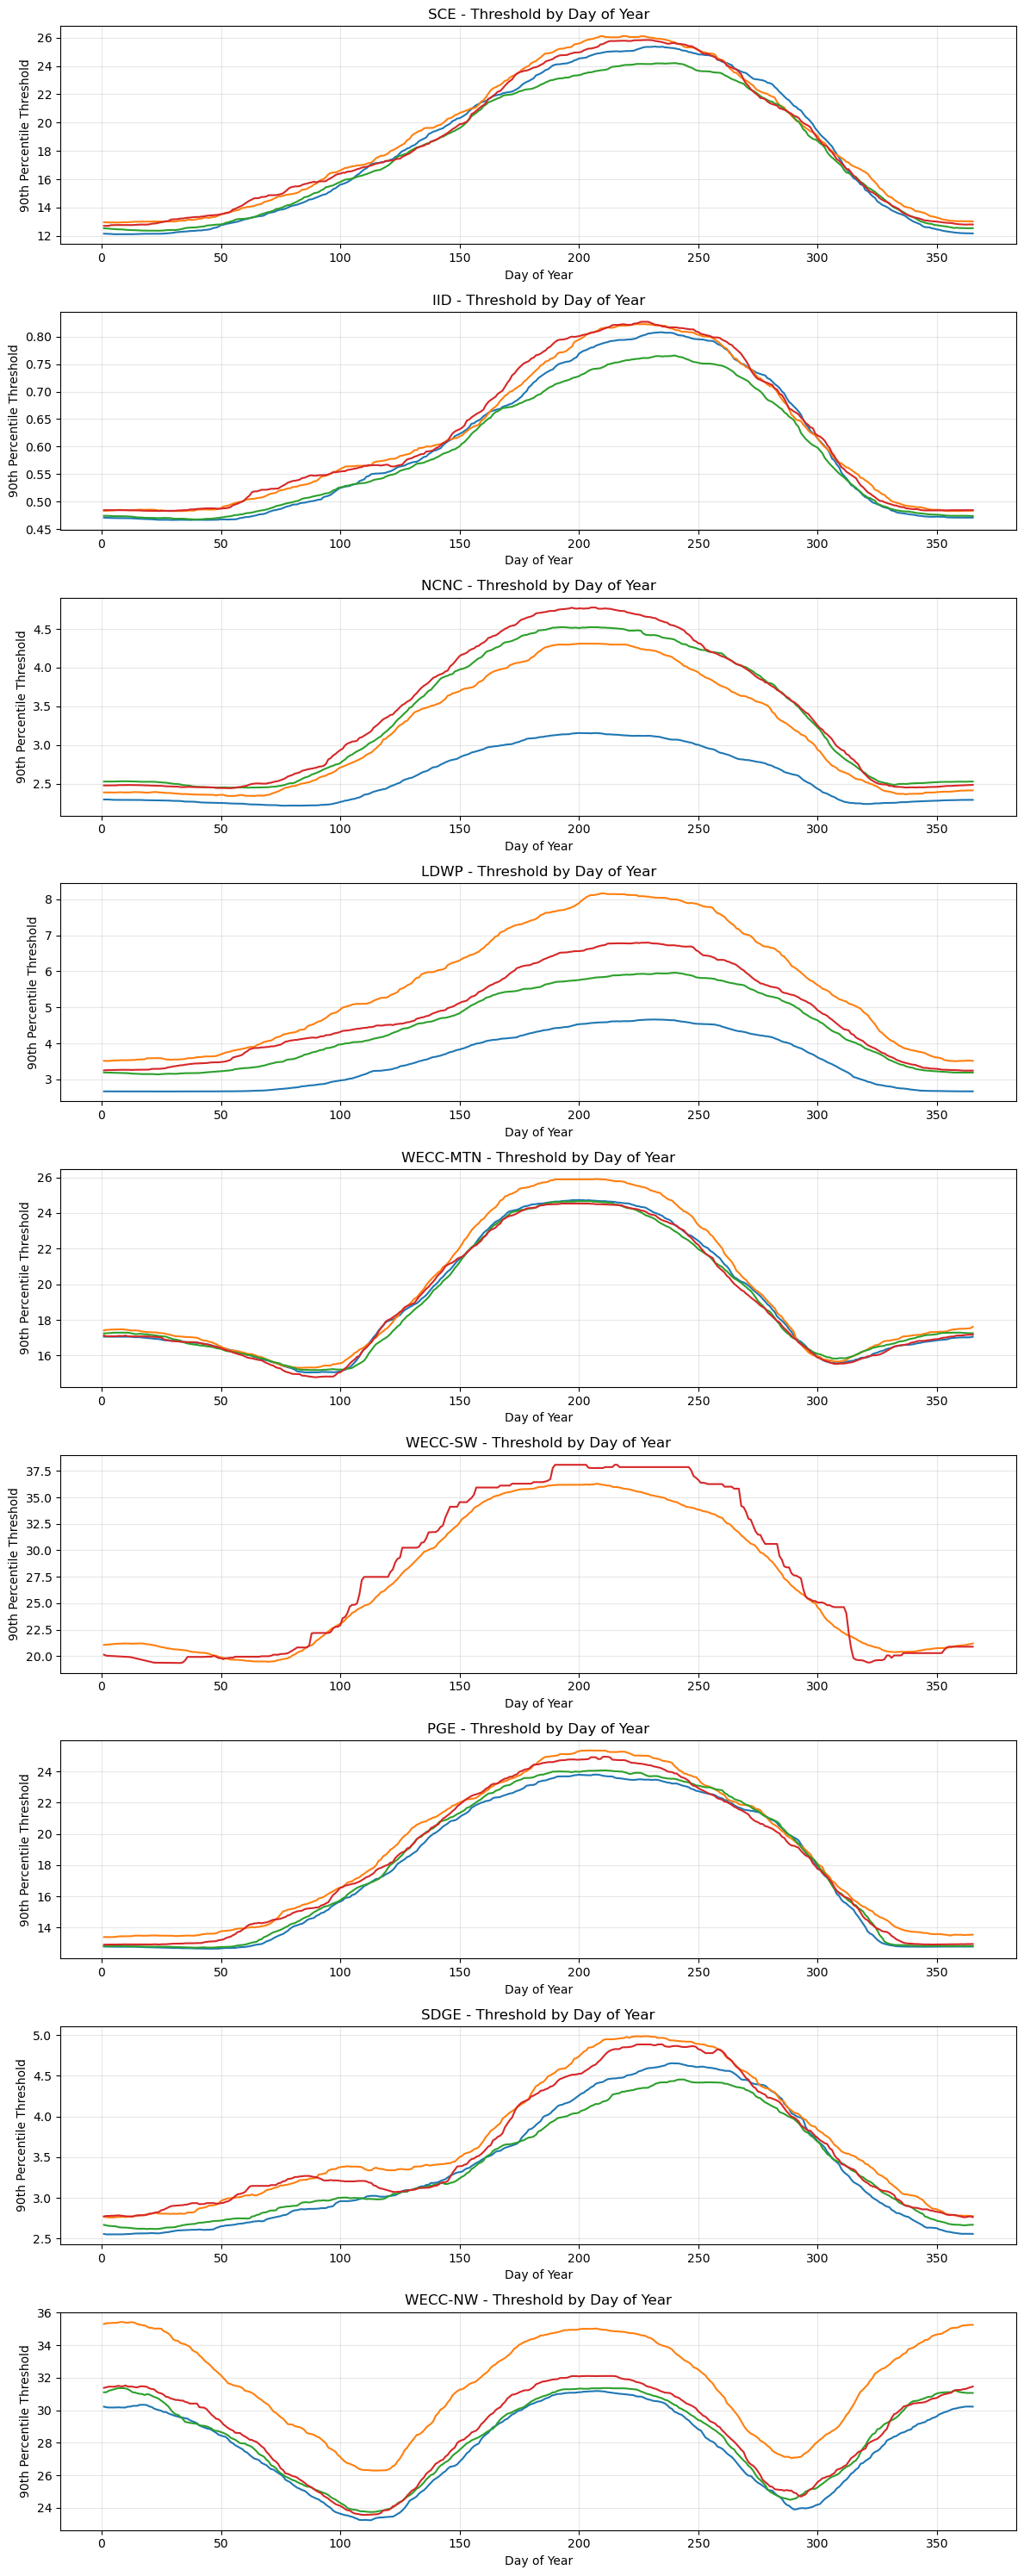

In [9]:
# Plot 90th percentile threshold by day of year for each variable
fig, axes = plt.subplots(len(percentile_90.region), 1, figsize=(12, 6 * 5))

for model in regional_thresholds.keys():
    thresh = regional_thresholds[model]
    for i, var in enumerate(thresh.region.values):
        thresh.isel(region=i).plot(ax=axes[i])
        axes[i].set_xlabel("Day of Year")
        axes[i].set_ylabel("90th Percentile Threshold")
        axes[i].set_title(f"{var} - Threshold by Day of Year")
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()

# 2. Calculate thresholded demand levels

In [10]:
# transform data to have day-of-year dimension
ds_doy = peak_demand_ds.copy(deep=True)
ds_doy = ds_doy.convert_calendar("noleap")

ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
ds_doy['year'] = ds_doy.time.dt.year
ds_doy = ds_doy.assign_coords(
    {"dayofyear":ds_doy.time.dt.dayofyear,
    "year":ds_doy.time.dt.year})
ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

for model in regional_thresholds.keys():
    thresh = regional_thresholds[model]
    ds_doy[model] = ds_doy[model] - thresh


highdemand_ds = ds_doy.stack(time=['year','dayofyear'])
highdemand_ds = highdemand_ds.reset_index("time").assign_coords(time=peak_demand_ds.time)
highdemand_ds = highdemand_ds.load()

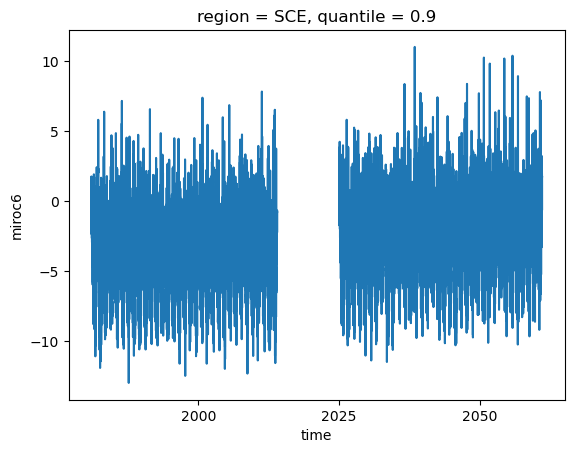

In [11]:
highdemand_ds.isel(region=0)['miroc6'].plot()

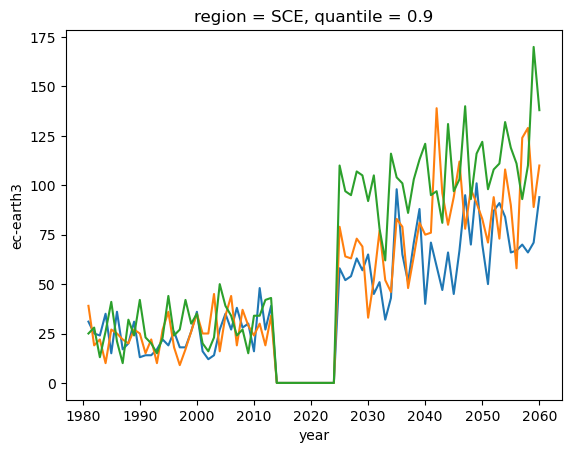

In [12]:
(highdemand_ds > 0).groupby('time.year').sum('time').isel(region=0)['miroc6'].plot()

(highdemand_ds > 0).groupby('time.year').sum('time').isel(region=0)['taiesm1'].plot()

(highdemand_ds > 0).groupby('time.year').sum('time').isel(region=0)['ec-earth3'].plot()

# 3. Calculate binary high demand mask

In [75]:
# Create binary mask (1 for high demand, 0 for normal demand)
highdemand_mask = xr.where(highdemand_ds > 0, 1, 0)

# Preserve NaN values where original data was missing
# This ensures missing data is not treated as zeros (normal demand days)
highdemand_mask = xr.where(highdemand_ds.isnull(), np.nan, highdemand_mask)

highdemand_mask.attrs['description'] = 'Binary high demand mask: 1 = high demand day (above threshold), 0 = not a high demand day, NaN = missing data'

for target_gwl in [0.8, 2.0]:

    for simulation in highdemand_ds.data_vars:
        demandmask = highdemand_mask[simulation]

        # slice to target GWL to save
        print(f"Calculating drought mask for GWL: {target_gwl}°C")
        # Get bounds for reference GWL period
        WRF_sim_name = sim_name_dict[simulation]
        model = WRF_sim_name.split("_")[1]
        ensemble_member = WRF_sim_name.split("_")[2]
        ref_start_year, ref_end_year = get_gwl_crossing_period(model, ensemble_member, target_gwl)

        demandmask = demandmask.sel(time=slice(f"{ref_start_year}-01-01",f"{ref_end_year}-12-31"))

        mask_output_file = f"../../data/drought_masks/demand_byregion_{simulation}_gwl{target_gwl}_demand_mask_only.zarr"

        demandmask.to_zarr(mask_output_file, mode='w', consolidated=True)



Calculating drought mask for GWL: 0.8°C
Calculating drought mask for GWL: 0.8°C
Calculating drought mask for GWL: 0.8°C
Calculating drought mask for GWL: 0.8°C
Calculating drought mask for GWL: 2.0°C
Calculating drought mask for GWL: 2.0°C
Calculating drought mask for GWL: 2.0°C
Calculating drought mask for GWL: 2.0°C


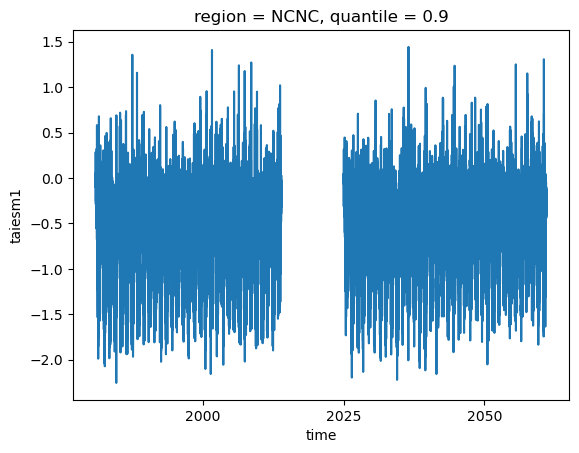

In [76]:
highdemand_ds[simulation].isel(region=2).plot()

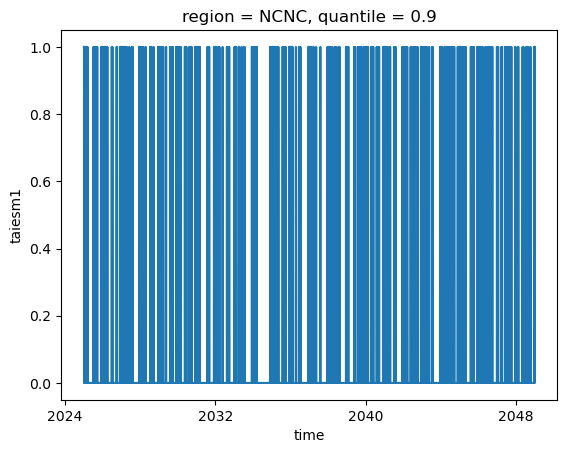

In [77]:
demandmask.isel(region=2).plot()

## 4. Annual Summary of High Demand Days

Plot annual sum of high demand days for each region and model

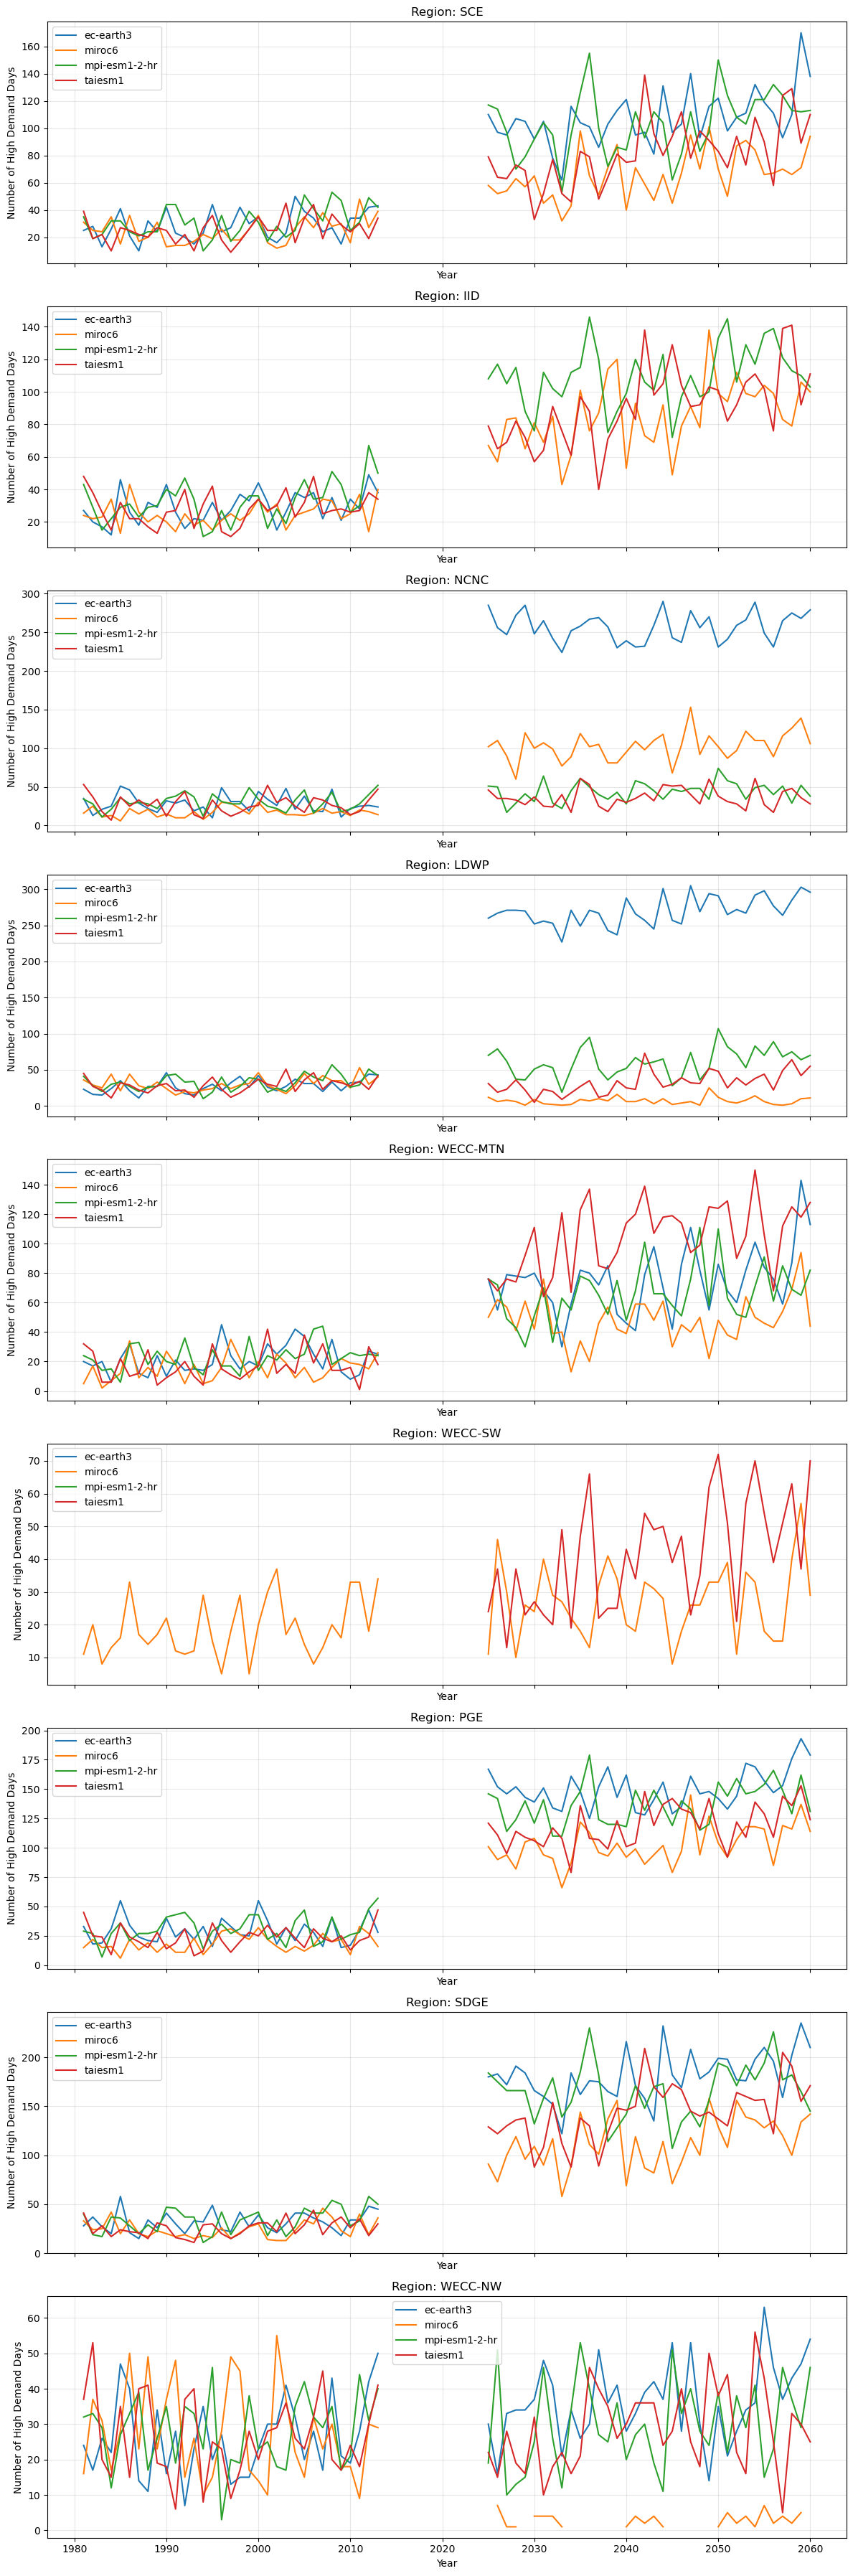

In [78]:
# Calculate annual sum of high demand days for each region and model
# Add year coordinate to highdemand_mask
highdemand_mask_annual = highdemand_mask.copy()
highdemand_mask_annual['year'] = highdemand_mask_annual.time.dt.year

# Group by year and sum for each region and model
annual_counts = highdemand_mask_annual.groupby('year').sum(dim='time')

# Create subplots - one axis per region
n_regions = len(annual_counts.region)
fig, axes = plt.subplots(n_regions, 1, figsize=(12, 4 * n_regions), sharex=True)

# Handle single region case
if n_regions == 1:
    axes = [axes]

# Plot each region
for i, region in enumerate(annual_counts.region.values):
    ax = axes[i]
    region_data = annual_counts.sel(region=region)
    
    # Plot each model for this region
    for var in region_data.data_vars:
        (region_data[var].where(region_data[var] >0)).plot(ax=ax, label=var)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of High Demand Days')
    ax.set_title(f'Region: {region}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Seasonal Change in High Demand Days (by GWL)

Calculate the change in average seasonal high demand days from reference (0.8°C) to future (2.0°C) GWL periods

In [79]:
# Set GWL periods
reference_gwl = 0.8
future_gwl = 2.0

# Dictionary to store seasonal averages for each model, region, and GWL
seasonal_changes = {}

# Get correct region names from the full dataset
region_names = highdemand_mask.region.values

for simulation in highdemand_mask.data_vars:
    print(f"Processing {simulation}...")
    
    # Load both reference and future period masks from saved zarr files
    ref_mask_file = f"../../data/drought_masks/demand_byregion_{simulation}_gwl{reference_gwl}_demand_mask_only.zarr"
    mask_ref_ds = xr.open_zarr(ref_mask_file)
    
    fut_mask_file = f"../../data/drought_masks/demand_byregion_{simulation}_gwl{future_gwl}_demand_mask_only.zarr"
    mask_fut_ds = xr.open_zarr(fut_mask_file)
    
    # Extract DataArray from Dataset (zarr files are loaded as Datasets)
    mask_ref = mask_ref_ds[list(mask_ref_ds.data_vars)[0]]
    mask_fut = mask_fut_ds[list(mask_fut_ds.data_vars)[0]]
    
    # Restore proper region names (in case zarr files have integer indices)
    mask_ref['region'] = region_names
    mask_fut['region'] = region_names
    
    # Add season coordinate
    mask_ref['season'] = mask_ref.time.dt.season
    mask_fut['season'] = mask_fut.time.dt.season
    
    # For each season: sum high demand days per season per year, then average across years
    # First group by year and season to get seasonal sums per" year
    ref_seasonal = mask_ref.groupby('time.year').apply(
        lambda x: x.groupby('season').sum(dim='time')
    )
    fut_seasonal = mask_fut.groupby('time.year').apply(
        lambda x: x.groupby('season').sum(dim='time')
    )
    
    # Average across years to get mean seasonal high demand days
    ref_seasonal_mean = ref_seasonal.mean(dim='year')
    fut_seasonal_mean = fut_seasonal.mean(dim='year')
    
    # Calculate change (future - reference)
    seasonal_change = fut_seasonal_mean - ref_seasonal_mean
    
    # Filter out invalid data: if reference OR future period has all zeros, set to NaN
    # Check if total high demand days across all seasons is zero
    ref_total = mask_ref.sum(dim='time')
    fut_total = mask_fut.sum(dim='time')
    
    # For each region, if either reference or future has zero total high demand days, set all seasons to NaN
    for region in seasonal_change.region.values:
        if ref_total.sel(region=region).values == 0 or fut_total.sel(region=region).values == 0:
            print(f"  Warning: {region} has all zeros in reference or future period - setting to NaN")
            seasonal_change.loc[dict(region=region)] = np.nan
    
    seasonal_changes[simulation] = seasonal_change
    

Processing ec-earth3...
Processing miroc6...
Processing mpi-esm1-2-hr...
Processing taiesm1...


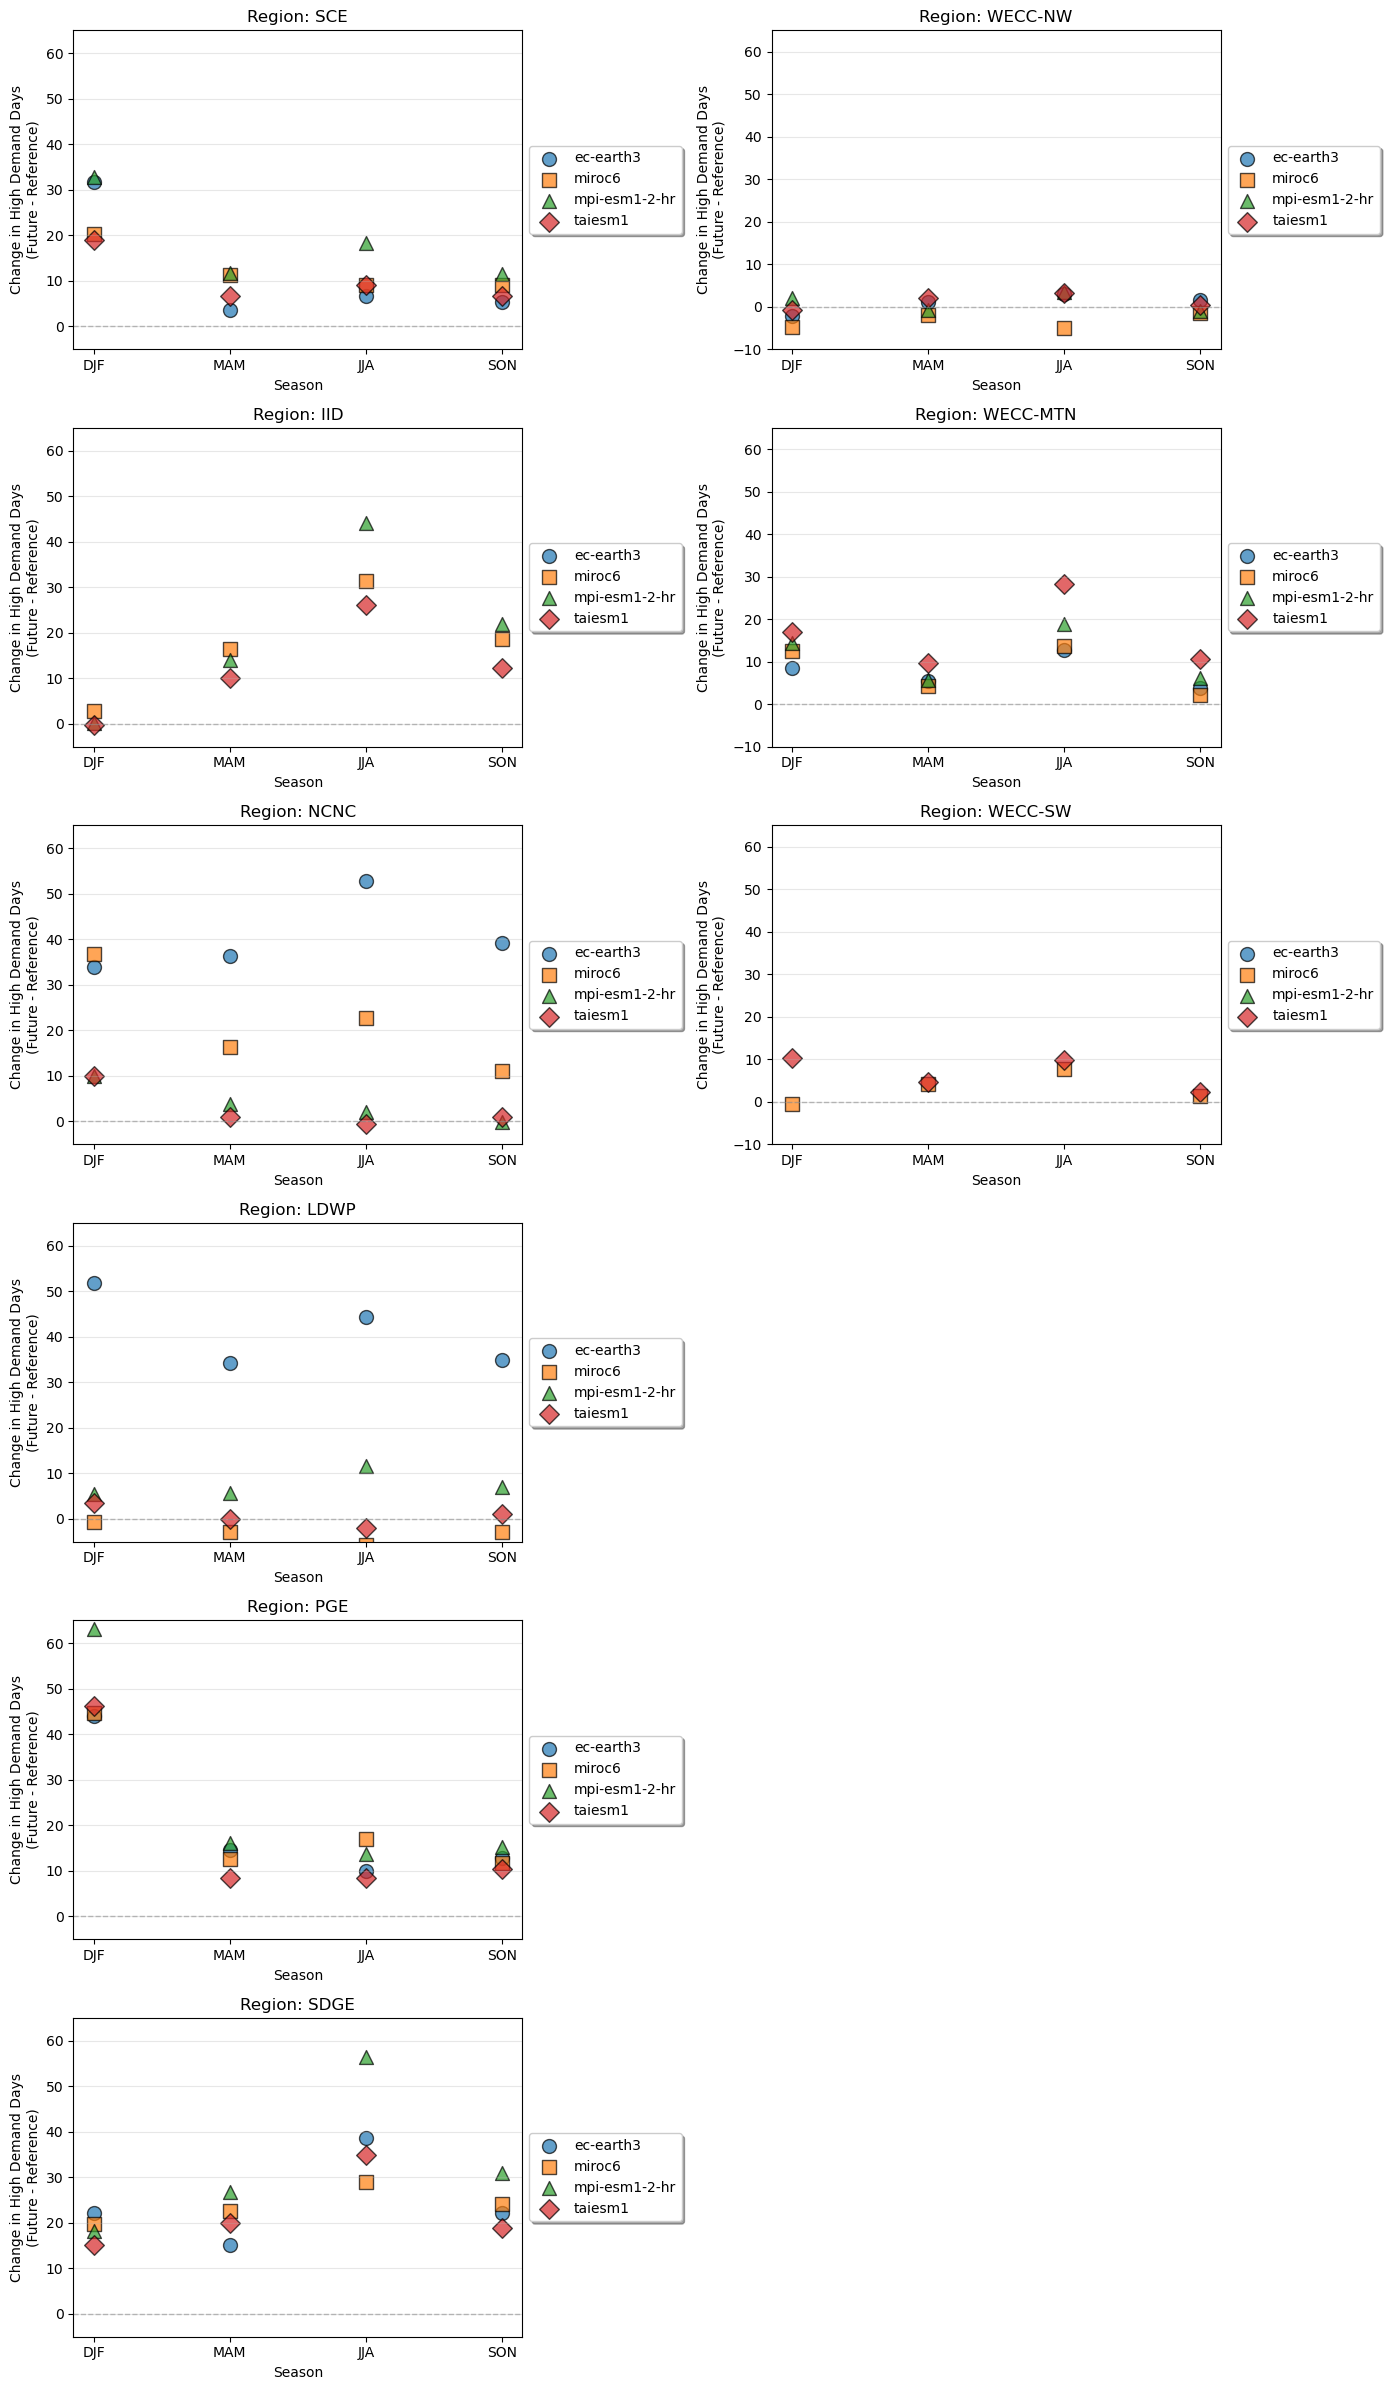

In [84]:
# Plot seasonal changes - two columns by region type
col1_regions = ['SCE', 'IID', 'NCNC', 'LDWP', 'PGE', 'SDGE']
col2_regions = ['WECC-NW', 'WECC-MTN', 'WECC-SW']

n_rows = max(len(col1_regions), len(col2_regions))
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))

# Define colors for each model
colors = {'ec-earth3': 'tab:blue', 'miroc6': 'tab:orange', 
          'mpi-esm1-2-hr': 'tab:green', 'taiesm1': 'tab:red'}
markers = {'ec-earth3': 'o', 'miroc6': 's', 
           'mpi-esm1-2-hr': '^', 'taiesm1': 'D'}

# Season order for x-axis
seasons = ['DJF', 'MAM', 'JJA', 'SON']
season_positions = {s: i for i, s in enumerate(seasons)}

# Plot column 1 regions
for i, region in enumerate(col1_regions):
    ax = axes[i, 0]
    
    # Plot each model
    for simulation in seasonal_changes.keys():
        change_data = seasonal_changes[simulation].sel(region=region)
        
        # Extract values for each season
        x_vals = []
        y_vals = []
        for season in seasons:
            if season in change_data.season.values:
                x_vals.append(season_positions[season])
                y_vals.append(float(change_data.sel(season=season).values))
        
        # Plot
        ax.scatter(x_vals, y_vals, 
                  label=simulation, 
                  color=colors.get(simulation, 'black'),
                  marker=markers.get(simulation, 'o'),
                  s=100, alpha=0.7, edgecolors='black', linewidth=1)
    
    # Add horizontal line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Formatting
    ax.set_xticks(range(len(seasons)))
    ax.set_xticklabels(seasons)
    ax.set_xlabel('Season')
    ax.set_ylabel('Change in High Demand Days\n(Future - Reference)')
    ax.set_title(f'Region: {region}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-5, 65)

# Plot column 2 regions
for i, region in enumerate(col2_regions):
    ax = axes[i, 1]
    
    # Plot each model
    for simulation in seasonal_changes.keys():
        change_data = seasonal_changes[simulation].sel(region=region)
        
        # Extract values for each season
        x_vals = []
        y_vals = []
        for season in seasons:
            if season in change_data.season.values:
                x_vals.append(season_positions[season])
                y_vals.append(float(change_data.sel(season=season).values))
        
        # Plot
        ax.scatter(x_vals, y_vals, 
                  label=simulation, 
                  color=colors.get(simulation, 'black'),
                  marker=markers.get(simulation, 'o'),
                  s=100, alpha=0.7, edgecolors='black', linewidth=1)
    
    # Add horizontal line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Formatting
    ax.set_xticks(range(len(seasons)))
    ax.set_xticklabels(seasons)
    ax.set_xlabel('Season')
    ax.set_ylabel('Change in High Demand Days\n(Future - Reference)')
    ax.set_title(f'Region: {region}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-10, 65)

# Hide unused subplots in column 2
for i in range(len(col2_regions), n_rows):
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()